### Импорт библиотек

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

/Users/nad/miniconda3/envs/sna/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Испорт функций

In [2]:
from funcs.simple_classifier_funcs import get_embeddings

### Обработка графа
Загружаем данные и удаляем самую большую компоненту

In [3]:
import os
os.chdir('../..')

In [30]:
# filename = 'data/graph_full.txt'
filename = 'data_arab/graph_collapse.txt'

G = nx.Graph()
G_with_orient = nx.DiGraph()

with open(filename, 'r') as file:
    for line in file:
        node1, node2 = line.strip().split()
        G.add_edge(node1, node2)
        G_with_orient.add_edge(node1, node2)

df = pd.read_csv('data_arab/graph_collapse_node_traits_2.txt', delimiter='\t')

df['fam'] = df['fam'].replace(['LTR/Copia', 'LTR/Gypsy'], 'LTR')

node_family_dict = df.set_index('node')['fam'].to_dict()
node_freq_dict = df.set_index('node')['cnt'].to_dict()
unique_fams = set(node_family_dict.values())
print(f"Number of unique families: {len(unique_fams)}")

# Удаление самой большой компоненты связности
components = list(nx.connected_components(G))
largest_component = max(components, key=len)
for node in largest_component:
    G.remove_node(node)
print(f"Number of components: {len(components) - 1}")

Number of unique families: 13
Number of components: 759


### Получаем эмбеддинги

In [5]:
# families = ['DNA/HAT', 'DNA/MuDR', 'Helitron', 'LINE', 'LTR/Copia']
families = ['Helitron', 'LINE', 'DNA/MuDR', 'LTR']
# families = unique_fams
G_not_full = G.copy()
for node in G.nodes():
    if node_family_dict[node] not in families:
        G_not_full.remove_node(node)

In [6]:
import pickle
# Проверяем, существует ли файл с эмбеддингами
file_path = 'data_arab/node2vec_embeddings3.pkl'
if os.path.exists(file_path):
    # Если файл существует, загружаем эмбеддинги из файла
    print("Чтение...")
    with open(file_path, "rb") as f:
        node_embeddings = pickle.load(f)
else:
    # Если файл отсутствует, генерируем эмбеддинги
    node_embeddings = get_embeddings(G_not_full, 50)
    # Сохраняем эмбеддинги в файл
    print("Сохранение...")
    with open(file_path, 'wb') as f:  
        pickle.dump(node_embeddings, f)
print("Завершено")


Чтение...
Завершено


#### Сохраняем эмбеддинги

In [7]:
import pickle
# Проверяем, существует ли файл с эмбеддингами
file_path = 'data_arab/node2vec_embeddings4.pkl'
if os.path.exists(file_path):
    # Если файл существует, загружаем эмбеддинги из файла
    print("Чтение...")
    with open(file_path, "rb") as f:
        node_embeddings2 = pickle.load(f)
else:
    # Если файл отсутствует, генерируем эмбеддинги
    node_embeddings2 = get_embeddings(G_not_full, 50)
    # Сохраняем эмбеддинги в файл
    print("Сохранение...")
    with open(file_path, 'wb') as f:  
        pickle.dump(node_embeddings2, f)
print("Завершено")


Чтение...
Завершено


### Обучаем модель

In [6]:
G = G_not_full

In [7]:
# Определение класса для каждой компоненты
remaining_components = list(nx.connected_components(G))
component_classes = []
component_nodes = []

for component in remaining_components:
    # Пропускаем маленькие
    if len(component) < 4:
        continue
    families = [node_family_dict[node] for node in component if
                node in node_family_dict and not pd.isna(node_family_dict[node])]
    if families:
        # Определение класса компоненты
        most_common_class = Counter(families).most_common(1)[0][0]
        component_classes.append(most_common_class)
        component_nodes.append(component)
print(len(component_nodes))


111


In [8]:
# families = ['Helitron', 'LINE', 'DNA/MuDR']
families = ['Helitron', 'LINE', 'DNA/MuDR', 'LTR']
# families = set(node_family_dict.values())
colors = plt.get_cmap('tab20', len(families))
fam_to_color = {cls: colors(i) for i, cls in enumerate(families)}
node_colors = [fam_to_color[node_family_dict[node]] for node in G_not_full.nodes]

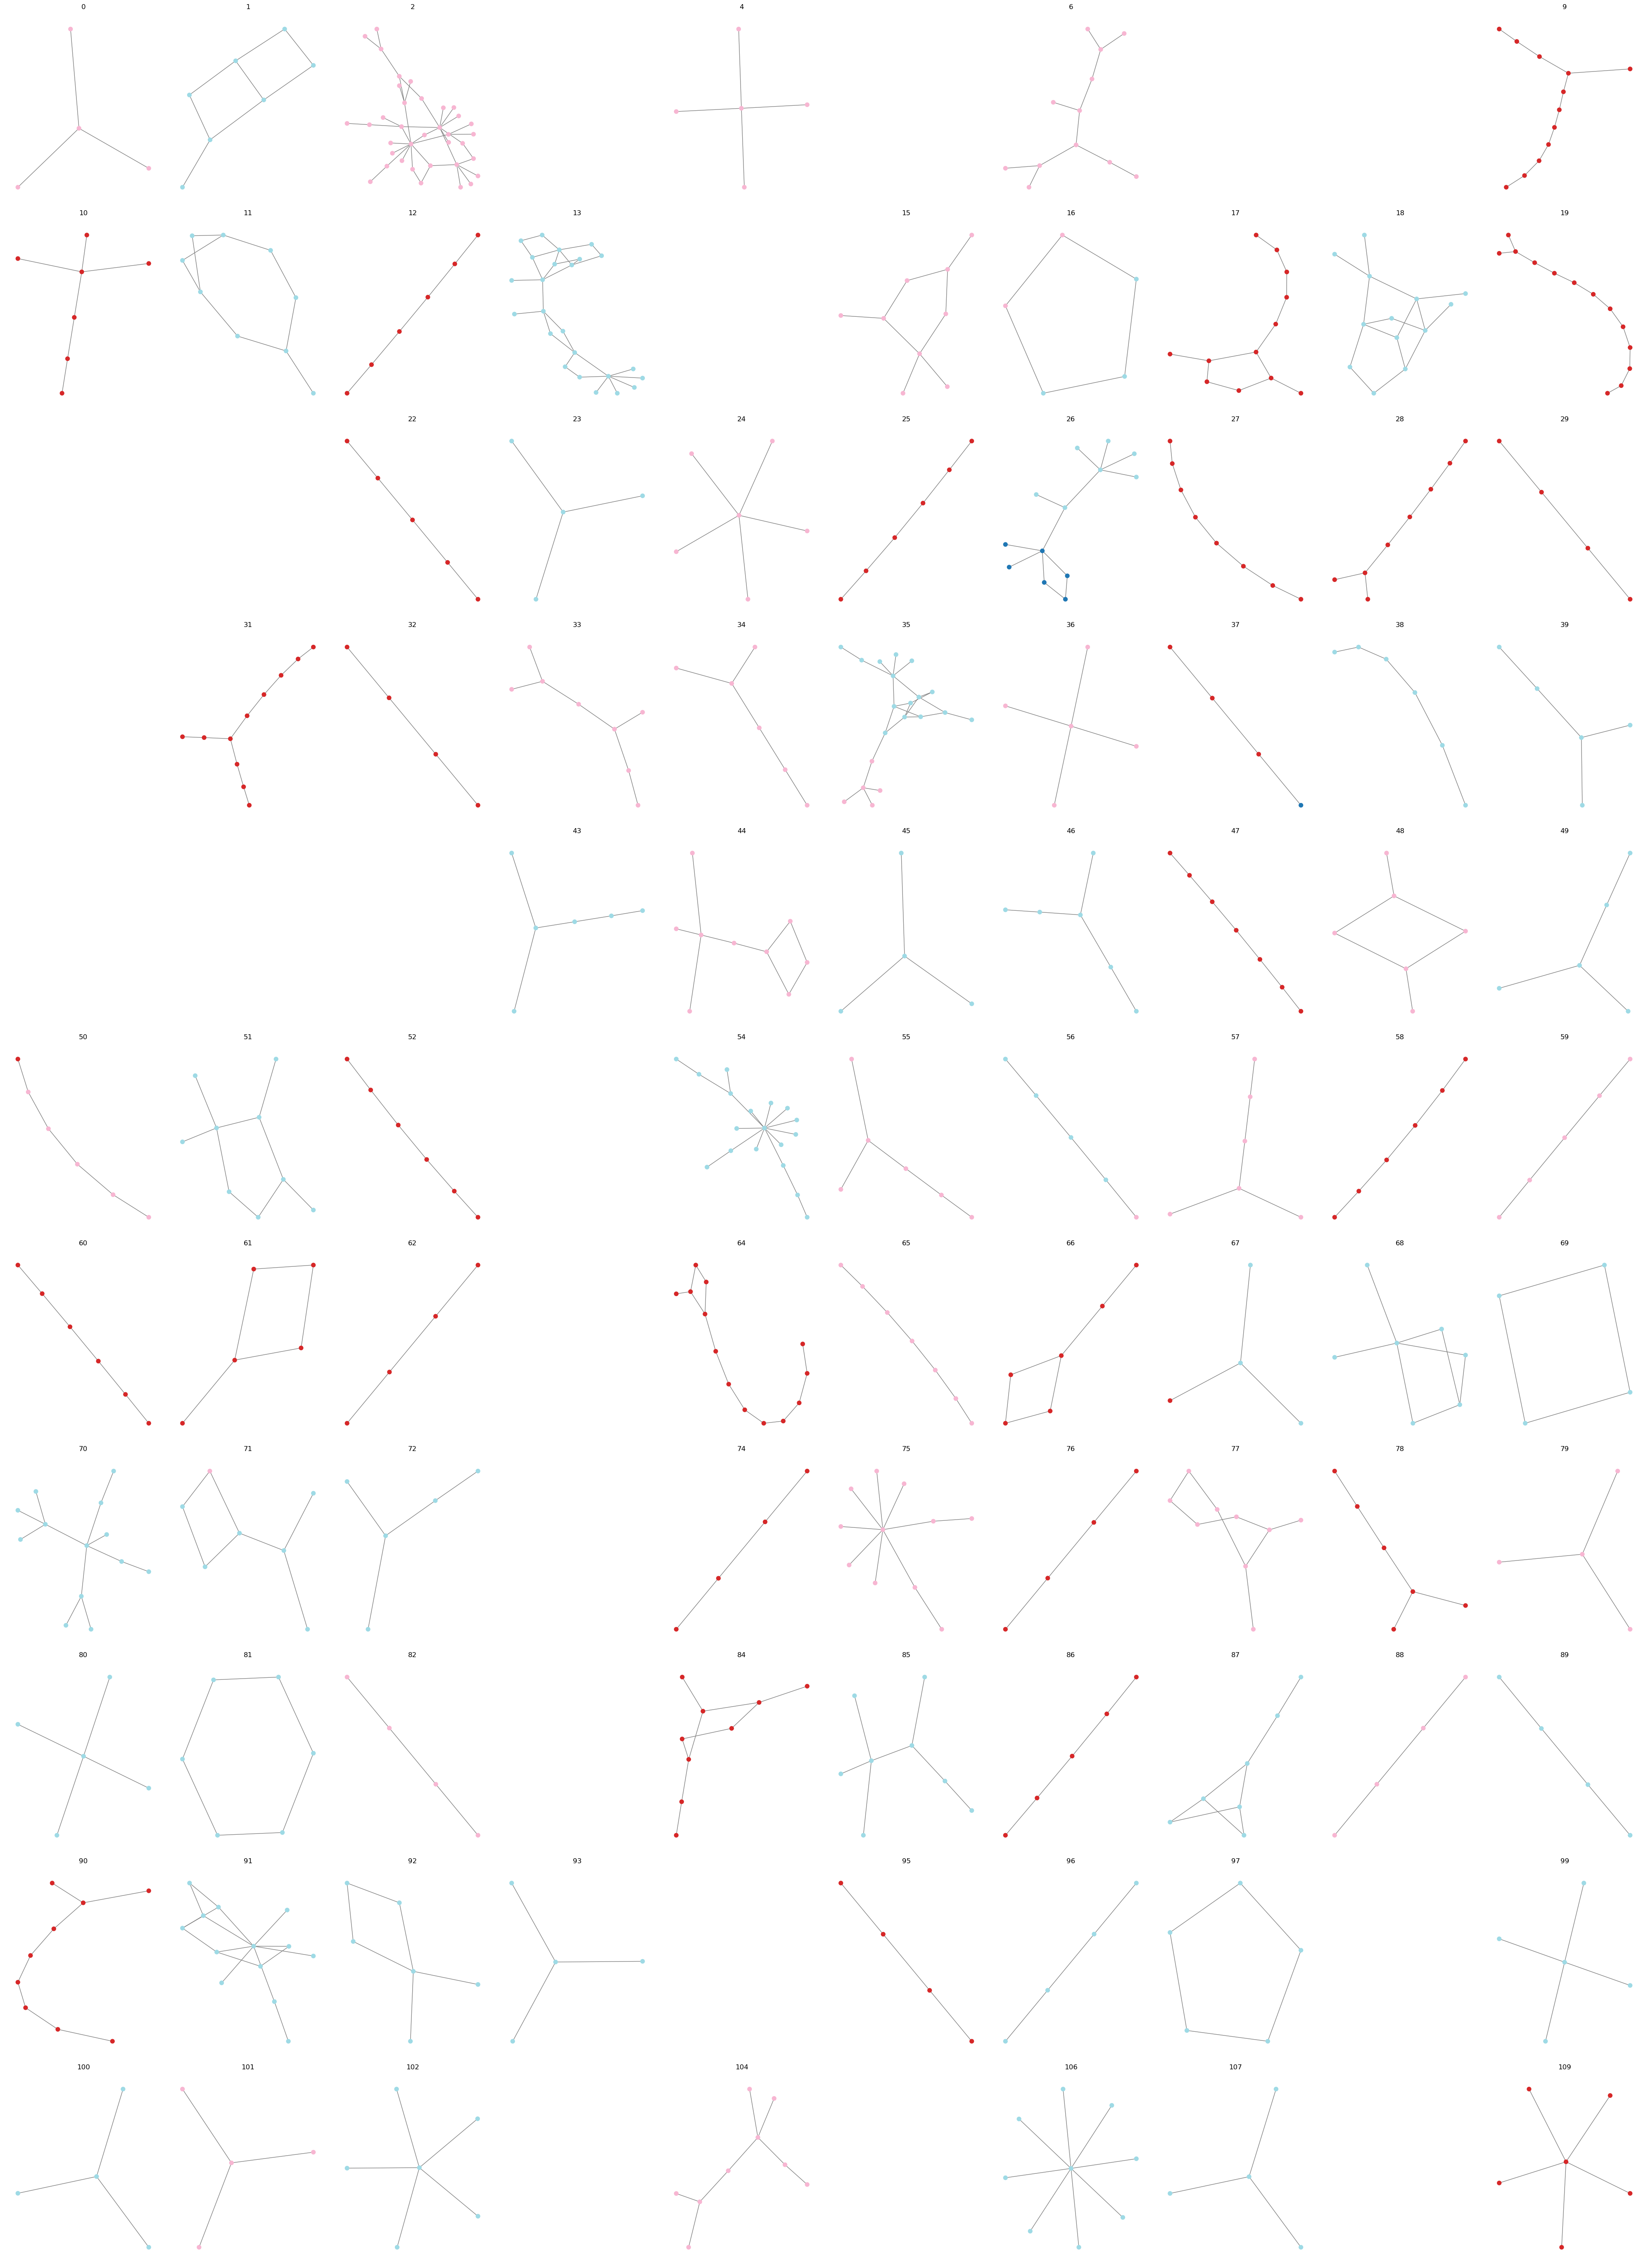

In [10]:
num_clusters = len(component_classes)
cols = 10
rows = (num_clusters // cols) + (num_clusters % cols > 0)

plt.figure(figsize=(40, 5 * rows))
highlighted_node = "SVgr_3_id_50111|2794"

for i, cluster_nodes in enumerate(component_nodes):
    if component_classes[i] == 'Helitron':
        continue
    # print(cluster_nodes)
    plt.subplot(rows, cols, i + 1)
    G_sub = G_not_full.subgraph(cluster_nodes).copy()
    # print(len(G_sub.nodes))
    pos = nx.spring_layout(G_sub)
    node_colors_sub = [fam_to_color[node_family_dict[node]] for node in G_sub.nodes]
    
    
    if highlighted_node in G_sub.nodes:
        node_colors_sub = [
            'red' if node == highlighted_node else node_colors_sub[j]
            for j, node in enumerate(G_sub.nodes)
        ]
        node_sizes_sub = [
            200 if node == highlighted_node else 50
            for node in G_sub.nodes
        ]
        print('found', i)
    else:
        node_sizes_sub = [50] * len(G_sub.nodes)
        
        
        
    nx.draw(
        G_sub, 
        pos, 
        with_labels=False, 
        node_color=node_colors_sub, 
        edge_color='gray', 
        node_size=node_sizes_sub, 
        font_size=1
    )
    plt.title(i)

plt.tight_layout()
plt.show()

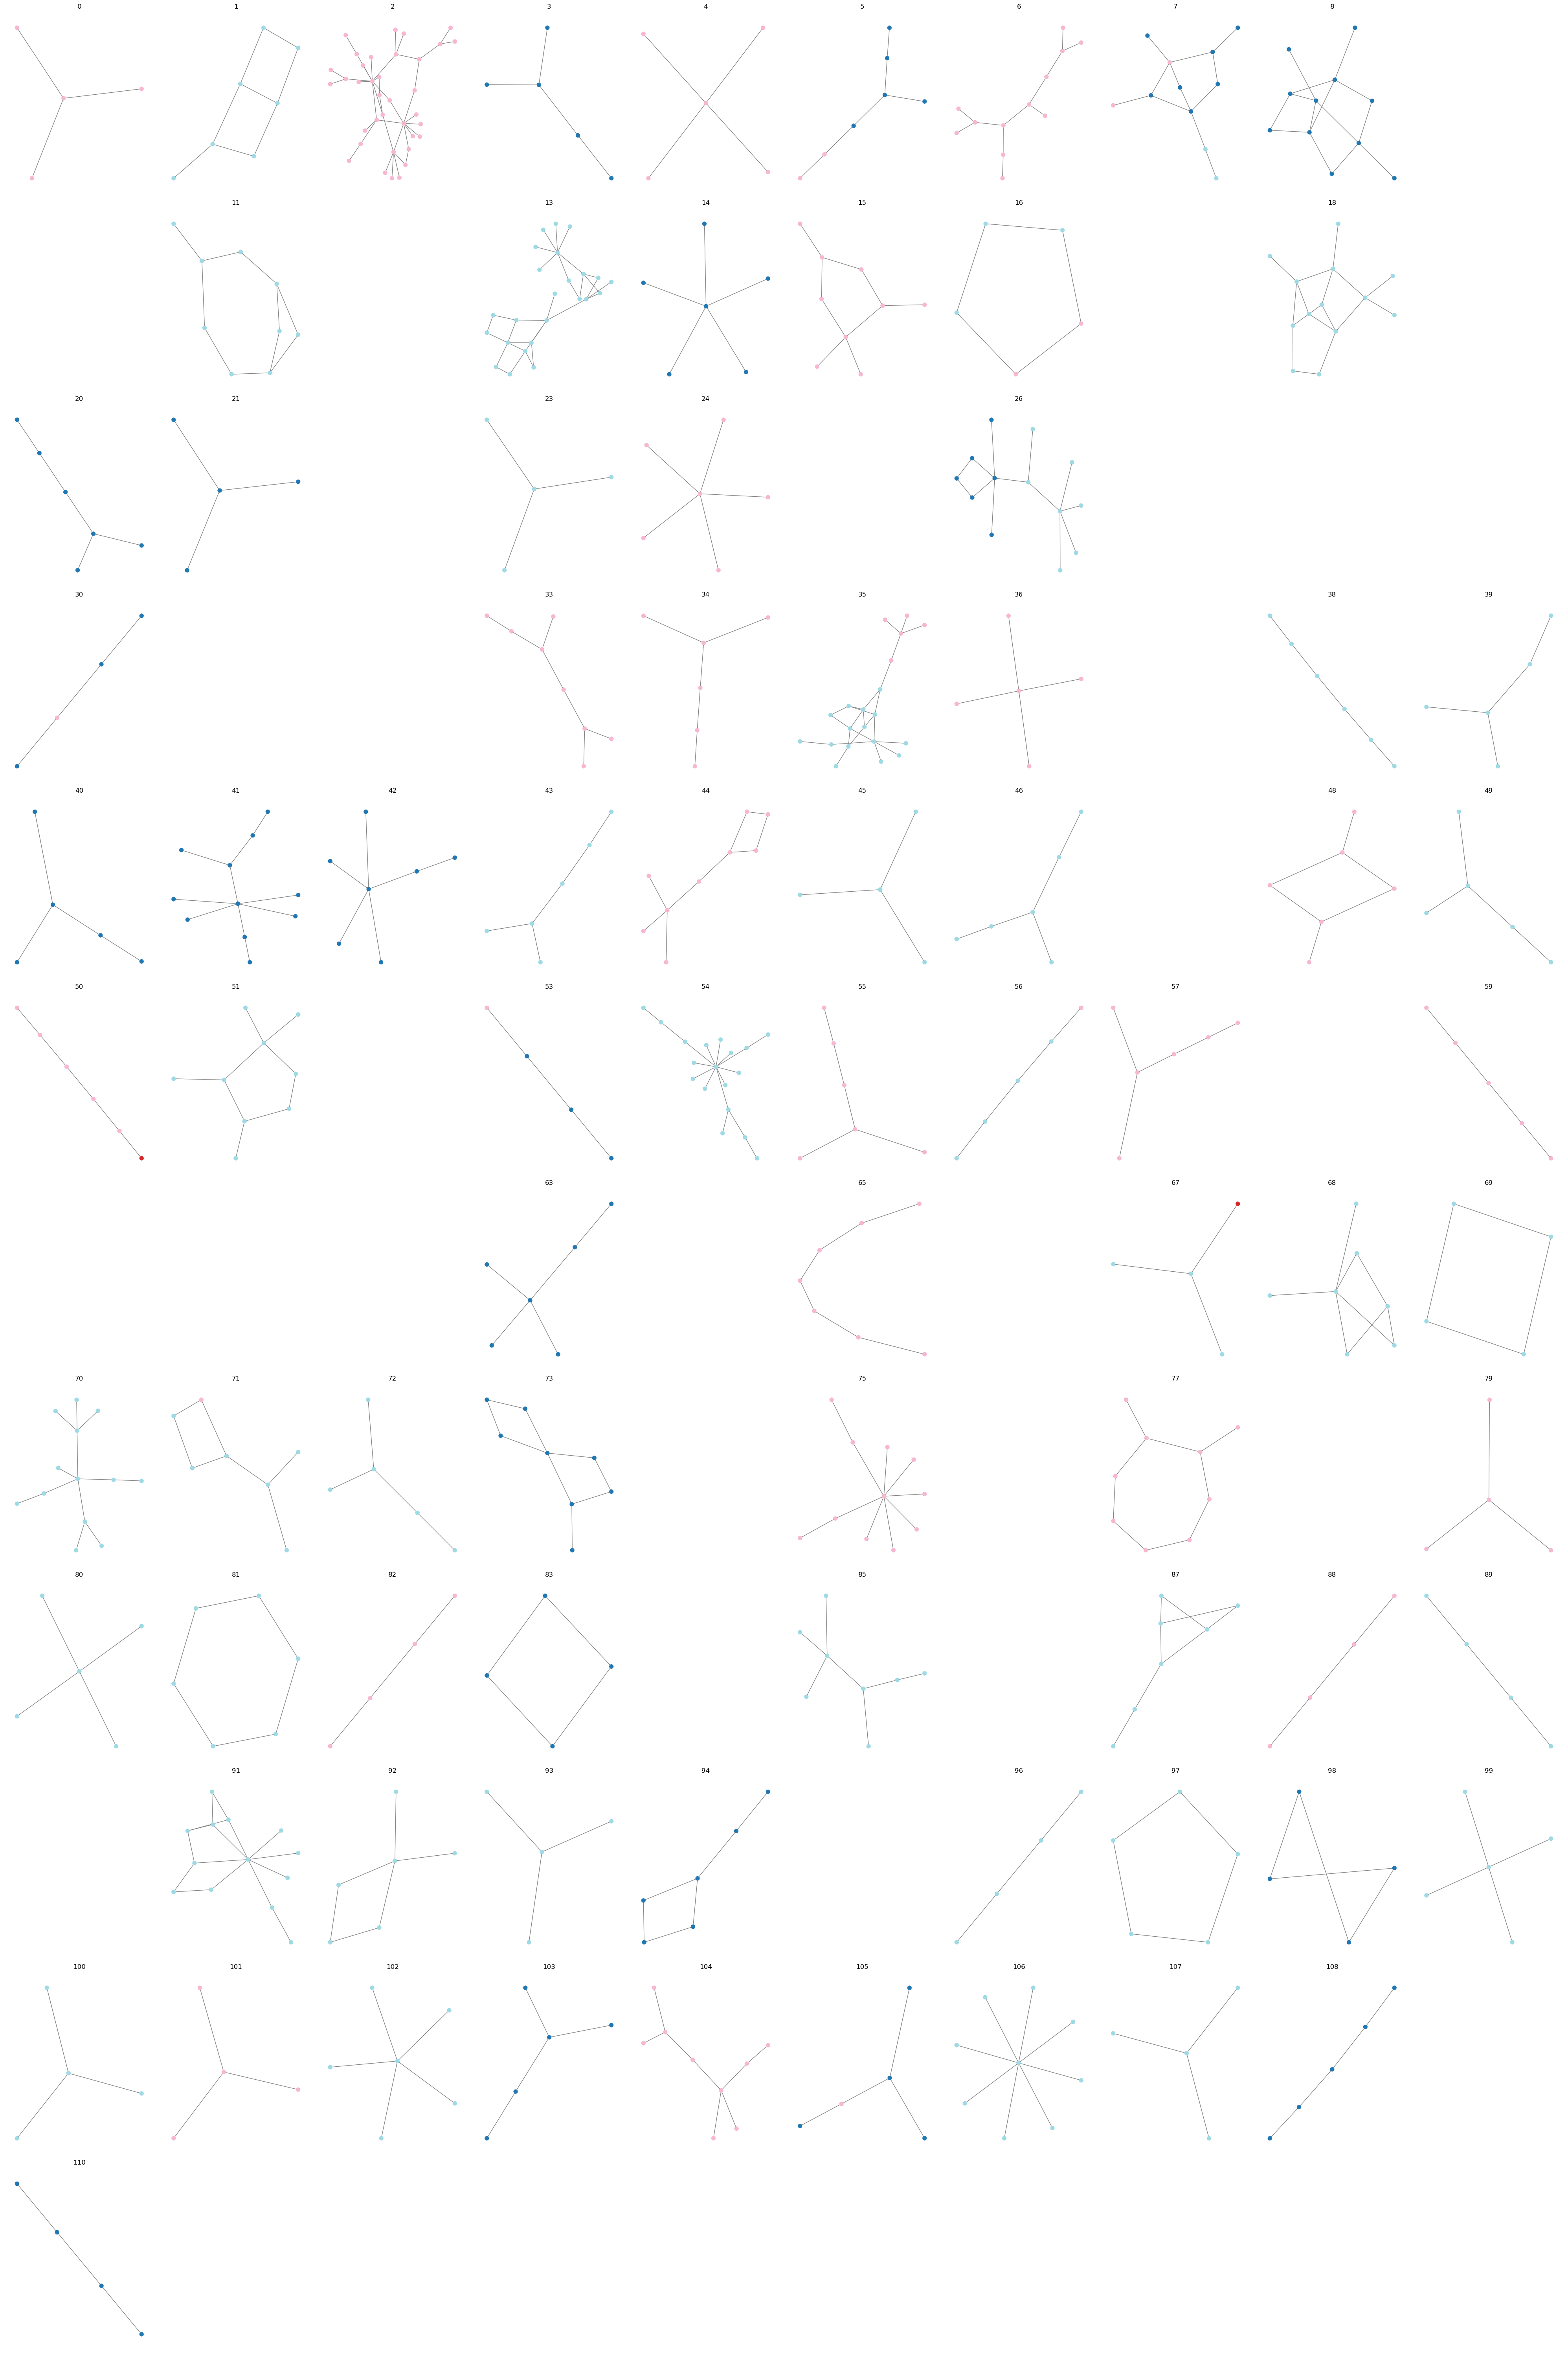

In [12]:
num_clusters = len(component_classes)
cols = 10
rows = (num_clusters // cols) + (num_clusters % cols > 0)

plt.figure(figsize=(40, 5 * rows))
highlighted_node = "SVgr_3_id_50111|2794"

for i, cluster_nodes in enumerate(component_nodes):
    if component_classes[i] == 'LINE':
        continue
    # print(cluster_nodes)
    plt.subplot(rows, cols, i + 1)
    G_sub = G_not_full.subgraph(cluster_nodes).copy()
    # print(len(G_sub.nodes))
    pos = nx.spring_layout(G_sub)
    node_colors_sub = [fam_to_color[node_family_dict[node]] for node in G_sub.nodes]
    
    
    if highlighted_node in G_sub.nodes:
        node_colors_sub = [
            'red' if node == highlighted_node else node_colors_sub[j]
            for j, node in enumerate(G_sub.nodes)
        ]
        node_sizes_sub = [
            200 if node == highlighted_node else 50
            for node in G_sub.nodes
        ]
        print('found', i)
    else:
        node_sizes_sub = [50] * len(G_sub.nodes)
        
        
        
    nx.draw(
        G_sub, 
        pos, 
        with_labels=False, 
        node_color=node_colors_sub, 
        edge_color='gray', 
        node_size=node_sizes_sub, 
        font_size=1
    )
    plt.title(i)

plt.tight_layout()
plt.show()

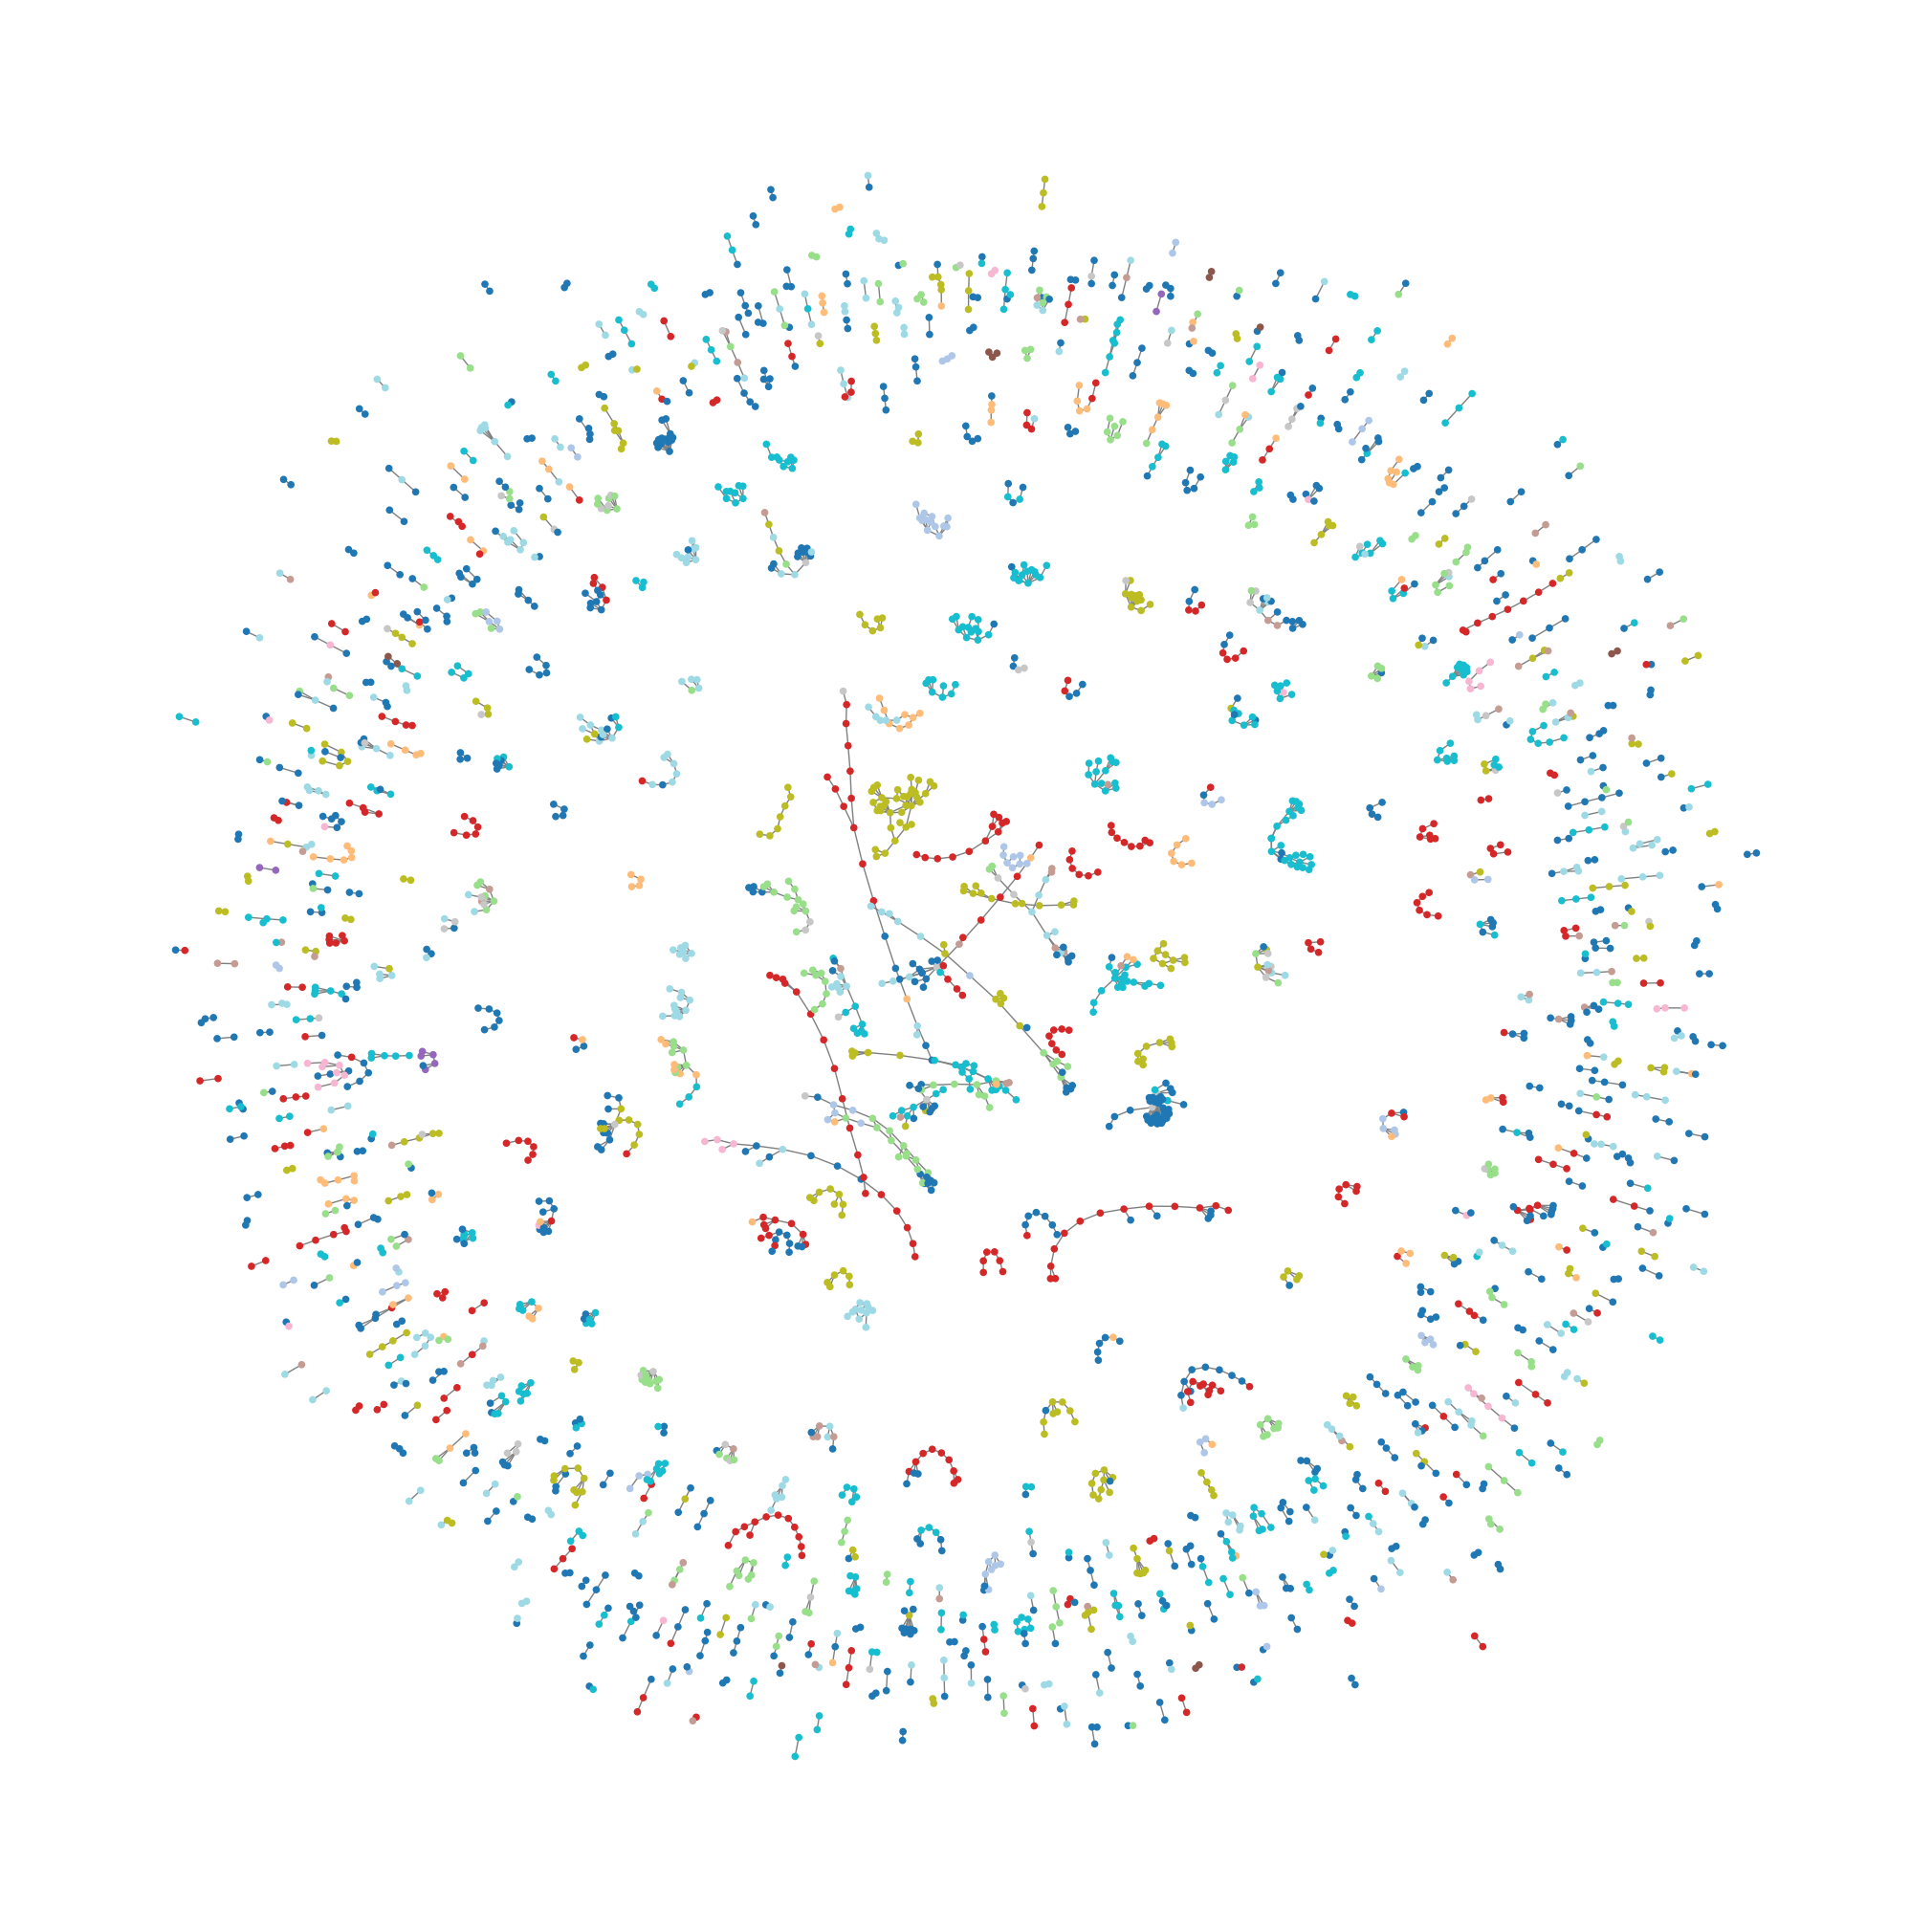

In [12]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G_not_full)
nx.draw(G_not_full, pos, with_labels=False, node_color=node_colors, edge_color='gray', node_size=20, font_size=1)

plt.show()
        

In [12]:
def count_specific_kmers(sequence, target_kmers):
    """
    Считает количество указанных k-меров в последовательности нуклеотидов.

    :param sequence: строка, представляющая последовательность нуклеотидов
    :param target_kmers: список k-меров, которые нужно искать
    :return: список чисел, где каждое число — количество соответствующего k-мера
    """
    kmers_count = {kmer: 0 for kmer in target_kmers}
    k = len(target_kmers[0])
    # Проверяем, чтобы длина последовательности позволяла выделить хотя бы один k-мер
    if len(sequence) < k:
        return [0] * len(target_kmers)
    
    # Проходим по строке и извлекаем k-меры
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i + k]
        # Если k-мер в целевом списке, увеличиваем счетчик
        if kmer in kmers_count:
            kmers_count[kmer] += 1
    
    # Возвращаем список чисел в порядке target_kmers
    return [kmers_count[kmer] for kmer in target_kmers]


In [13]:
import itertools
import random

def generate_random_kmers(k, n):
    """
    Находит все возможные k-меры и выбирает n случайных.

    :param k: длина k-мера
    :param n: количество случайных k-меров для возврата
    :return: список из n случайных k-меров
    """
    alphabet="ACGT"
    all_kmers = [''.join(kmer) for kmer in itertools.product(alphabet, repeat=k)]

    if n > len(all_kmers):
        raise ValueError(f"Количество возможных k-меров меньше, чем n")
    return random.sample(all_kmers, n)

In [14]:
# Генерируем рандомные k-меры
random_kmers = generate_random_kmers(4, 100)

In [15]:
node2name = pd.read_csv('data_arab/graph_collapse_nodes.txt', sep='\t')
node2name = node2name.drop_duplicates(subset=['node'], keep='first')
node2name_dict = node2name.set_index('node')['name'].to_dict()
node2name.head()

node                   name
0     N1  SVgr_1_id_100160|5237
17    N2   SVgr_1_id_100166|888
196   N3  SVgr_1_id_100331|1746
219   N4  SVgr_1_id_100333|4973
239   N5   SVgr_1_id_100418|272

In [16]:
def parse_fasta(file_path):
    name2seq = {}
    with open(file_path, 'r') as fasta_file:
        current_name = None
        current_sequence = []
        for line in fasta_file:
            line = line.strip()
            if line.startswith(">"):
                if current_name:
                    name2seq[current_name] = "".join(current_sequence)
                current_name = line[1:]  # Убираем символ ">" и сохраняем имя
                current_sequence = []
            else:
                current_sequence.append(line)
        if current_name:
            name2seq[current_name] = "".join(current_sequence)  # Добавляем последнюю запись
    return name2seq

fasta_file_path = 'data_arab/sv_pangen_seq_sv_big.fasta'
name2seq = parse_fasta(fasta_file_path)

In [93]:
# Создание набора данных на уровне узлов
X, y = [], []

for component, component_label in zip(component_nodes, component_classes):
    G_sub = G_not_full.subgraph(component).copy()
    n_nodes = len(G_sub.nodes())
    degrees = [deg for _, deg in G_sub.degree()]
    mean_degree = sum(degrees) / len(degrees) if len(degrees) > 0 else 0
    
    number_nodes = len(G_sub.nodes())
    
    max_degrees = sorted(degrees)[:3]
    
    # max_freq = max([node_freq_dict[node] for node in list(G_sub.nodes())])
    
    freqs = sorted([node_freq_dict[node] for node in list(G_sub.nodes())], reverse=True)[:3]
    
    # node_with_max_freq = max((node for node in node_freq_dict if node in G_sub.nodes()), key=node_freq_dict.get, default=None)
    
    # Составим последовательость 
    kmer_counts = [0] * len(random_kmers)
    
    for node in list(G_sub.nodes()):
        name = node2name_dict[node]
        sequecnce = name2seq[name]
        kmer_count = count_specific_kmers(sequecnce, random_kmers)
        
        kmer_counts = [x + y for x, y in zip(kmer_counts, kmer_count)]
    
    sum_len = 0
    for node in list(G_sub.nodes()):
        name = node2name_dict[node]
        sequence = name2seq[name]
        len_seq = len(sequence)
        sum_len += len_seq
    
    kmer_counts = [x / sum_len for x in kmer_counts]
    
    min_degree_count = 0
    for _, deg in G_sub.degree():
        if deg == 1:
            min_degree_count += 1
        
    
    embedding = [mean_degree, number_nodes, min_degree_count] + max_degrees + freqs + kmer_counts
    X.append(embedding)  # Добавляем эмбеддинги узла
    y.append(component_label)  # Метка компоненты


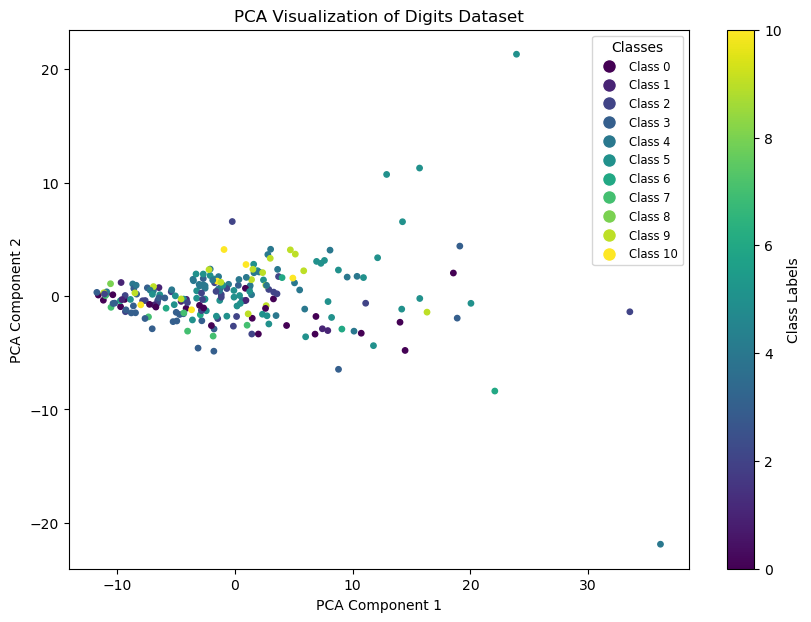

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

# Преобразование строковых меток в числа
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', s=15)
plt.colorbar(scatter, label='Class Labels')
plt.title("PCA Visualization of Digits Dataset")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
unique_classes = np.unique(y_encoded)
class_colors = scatter.cmap(scatter.norm(unique_classes))

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'Class {cls}', 
           markerfacecolor=class_colors[i], markersize=10)
    for i, cls in enumerate(unique_classes)
]
plt.legend(handles=legend_elements, title="Classes", loc="best", fontsize="small")

plt.show()


/Users/nad/miniconda3/envs/sna/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


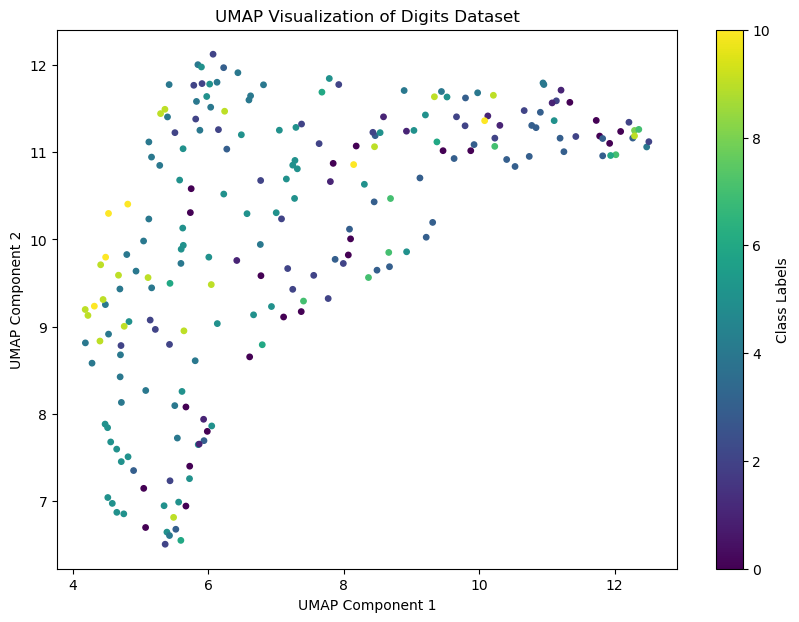

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Преобразование меток в числовой формат
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_encoded, cmap='viridis', s=15)
plt.colorbar(scatter, label='Class Labels')
plt.title("UMAP Visualization of Digits Dataset")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


In [107]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

RandomForestClassifier(random_state=42)

In [108]:
import pickle
# Сохранение модели
file_path = 'random_forest01.pkl'
with open(file_path, 'wb') as f:  
    pickle.dump(clf, f)
print("Завершено")

Завершено


Выгружаем данные про partition, чтобы дополнить train данные

In [28]:
file_path = 'clusters_leiden.pkl'
print("Чтение...")
with open(file_path, "rb") as f:
    clusters_leiden = pickle.load(f)
print("Завершено")

Чтение...
Завершено


In [29]:
file_path = 'families_clusters_leiden.pkl'
print("Чтение...")
with open(file_path, "rb") as f:
    families_clusters_leiden = pickle.load(f)
print("Завершено")

Чтение...
Завершено


In [37]:
# Еще раз загружаем граф
filename = 'data_arab/graph_collapse.txt'

G = nx.Graph()
G_with_orient = nx.DiGraph()

with open(filename, 'r') as file:
    for line in file:
        node1, node2 = line.strip().split()
        G.add_edge(node1, node2)
        G_with_orient.add_edge(node1, node2)

In [94]:
families = ['Helitron', 'LINE', 'DNA/MuDR', 'LTR']
for component, component_label in zip(clusters_leiden, families_clusters_leiden):
    if len(component) < 3:
        continue
    if component_label not in families:
        continue
    G_sub = G.subgraph(list(component)).copy()
    n_nodes = len(G_sub.nodes())
    degrees = [deg for _, deg in G_sub.degree()]
    mean_degree = sum(degrees) / len(degrees) if len(degrees) > 0 else 0
    
    number_nodes = len(G_sub.nodes())
    
    max_degrees = sorted(degrees)[:3]
    
    freqs = sorted([node_freq_dict[node] for node in list(G_sub.nodes())], reverse=True)[:3]
    
    # Составим последовательость 
    kmer_counts = [0] * len(random_kmers)
    
    for node in list(G_sub.nodes()):
        name = node2name_dict[node]
        sequecnce = name2seq[name]
        kmer_count = count_specific_kmers(sequecnce, random_kmers)
        
        kmer_counts = [x + y for x, y in zip(kmer_counts, kmer_count)]
    
    sum_len = 0
    for node in list(G_sub.nodes()):
        name = node2name_dict[node]
        sequence = name2seq[name]
        len_seq = len(sequence)
        sum_len += len_seq
    
    kmer_counts = [x / sum_len for x in kmer_counts]
    
    min_degree_count = 0
    for _, deg in G_sub.degree():
        if deg == 1:
            min_degree_count += 1
        
    
    embedding = [mean_degree, number_nodes, min_degree_count] + max_degrees + freqs + kmer_counts
    X.append(embedding)  # Добавляем эмбеддинги узла
    y.append(component_label)  # Метка компоненты

In [96]:
lengths = [len(row) for row in X]
print(set(lengths))

{109}


In [97]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

clf = RandomForestClassifier(random_state=42)

# Кросс-валидация
y_pred_cv = cross_val_predict(clf, X, y, cv=5)

# Результат
print(classification_report(y, y_pred_cv))

# Таблица сопряженности
data_cv = pd.DataFrame({'1': y, '2': y_pred_cv})
contingency_table_cv = pd.crosstab(data_cv['1'], data_cv['2'])

print(contingency_table_cv)

              precision    recall  f1-score   support

    DNA/MuDR       0.71      0.81      0.76        67
    Helitron       0.83      0.87      0.85        69
        LINE       0.89      0.76      0.82        42
         LTR       0.88      0.74      0.80        38

    accuracy                           0.81       216
   macro avg       0.83      0.79      0.81       216
weighted avg       0.81      0.81      0.81       216

Array2    DNA/MuDR  Helitron  LINE  LTR
Array1                                 
DNA/MuDR        54         9     1    3
Helitron         8        60     0    1
LINE             9         1    32    0
LTR              5         2     3   28


Балансировка классов

In [104]:
def balance_classes(X, y):
    X = np.array(X)
    y = np.array(y)
    # Определяем количество элементов в каждом классе
    class_counts = Counter(y)
    min_count = min(class_counts.values())

    # Собираем индексы для каждого класса
    indices_by_class = {cls: np.where(y == cls)[0] for cls in class_counts}

    # Оставляем только min_count элементов для каждого класса
    balanced_indices = []
    for cls, indices in indices_by_class.items():
        balanced_indices.extend(indices[:min_count])

    np.random.shuffle(balanced_indices)

    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]

    return X_balanced, y_balanced

In [105]:
X, y = balance_classes(X, y)

In [106]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

clf = RandomForestClassifier(random_state=42)

# Кросс-валидация
y_pred_cv = cross_val_predict(clf, X, y, cv=5)

# Результат
print(classification_report(y, y_pred_cv))

data_cv = pd.DataFrame({'1': y, '2': y_pred_cv})
contingency_table_cv = pd.crosstab(data_cv['1'], data_cv['2'])

print(contingency_table_cv)

              precision    recall  f1-score   support

    DNA/MuDR       0.79      0.82      0.81        38
    Helitron       0.82      0.87      0.85        38
        LINE       0.89      0.82      0.85        38
         LTR       0.84      0.84      0.84        38

    accuracy                           0.84       152
   macro avg       0.84      0.84      0.84       152
weighted avg       0.84      0.84      0.84       152

Array2    DNA/MuDR  Helitron  LINE  LTR
Array1                                 
DNA/MuDR        31         3     1    3
Helitron         3        33     1    1
LINE             3         2    31    2
LTR              2         2     2   32


In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)
# Сохранение модели
file_path = 'random_forest01_balanced.pkl'
with open(file_path, 'wb') as f:  
    pickle.dump(clf, f)
print("Завершено")